In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io
import multiprocessing as mp
from systems import *
import os
import Belousov_Zhabotinsky as BZ
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


In [2]:
N = 5  # Number of variables
F = 8  # Forcing
def L96(x):
    """Lorenz 96 model with constant forcing"""
    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d
def J_L96(x):
    """Lorenz 96 model with constant forcing"""
    # Setting up vector
    J = np.zeros(N,N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        J[i,(i + 1) % N] =  x[i - 1]
        J[i,i] = -1
        J[i,i - 1] = (x[(i + 1) % N] - x[i - 2])
        J[i,i - 2] =  -x[i - 1]
    return J    
def lorentz(x, sigma = 10, rho = 28, beta = 8/3):
    dx = np.zeros((3,))
    dx[0] = sigma * (x[1] - x[0])
    dx[1] = x[0]*(rho - x[2]) - x[1]
    dx[2] = x[0] * x[1] - beta * x[2]
    return dx
def Jlorentz(x, sigma = 10, rho = 28, beta = 8/3):
    J=[[-sigma,    sigma,       0],
       [rho - x[2],     -1,   -x[0]],
       [x[1],           x[0], -beta]]
    return J
def aa(x, sigma = 10, rho = 28, beta = 8/3):
    dx = np.zeros((3,))
    dx[0] =  - x[0]
    dx[1] =  - x[1]
    dx[2] =  - x[2]
    return dx
def Jaa(x, sigma = 10, rho = 28, beta = 8/3):
    J=- np.eye(3)
    return np.array(J)


In [3]:
def wtf_diff(x,axis=1):
    s = list(x.shape)
    x = x.reshape([-1,s[axis]])
    s[axis]-=1
    d = np.diff(x)
    return d.reshape(s)

In [4]:
def sample_spherical(npoints, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec

xrange, yrange, zrange = ((-30,30),(-40,40),(0,70))
cent = np.expand_dims(np.array([np.mean(xrange),np.mean(yrange),np.mean(zrange)]),axis=1)
cent = np.expand_dims(np.array([0,0,35]),axis=1)

abc = 2*np.expand_dims(np.array([30,40,35]),axis=1)
pnts = sample_spherical(1500,ndim=3)*abc + cent


In [5]:
pnts[:,0]

array([-34.32616881, -59.11919309,  10.09413395])

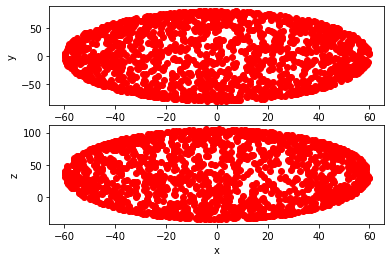

In [6]:
def plt5(x):
    plt.figure()
    plt.subplot(4,1,1)
    if len(x.shape)==2:
        plt.scatter(x[:,0],x[:,1],c='r')
        plt.ylabel('y')
        plt.subplot(4,1,2)
        plt.scatter(x[:,0],x[:,2],c='r')
        plt.ylabel('z')
        plt.subplot(4,1,3)
        plt.scatter(x[:,0],x[:,3],c='r')
        plt.ylabel('a')
        plt.subplot(4,1,4)
        plt.scatter(x[:,0],x[:,4],c='r')
    else:
        for n in range(x.shape[1]):
            plt.scatter(x[:,n,0],x[:,n,1])
        plt.ylabel('y')
        plt.subplot(4,1,2)
        for n in range(x.shape[1]):
            plt.scatter(x[:,n,0],x[:,n,2])
        plt.ylabel('z')
        plt.subplot(4,1,3)
        for n in range(x.shape[1]):
            plt.scatter(x[:,n,0],x[:,n,3])
        plt.ylabel('a')
        plt.subplot(4,1,4)
        for n in range(x.shape[1]):
            plt.scatter(x[:,n,0],x[:,n,4])
    plt.ylabel('b')
    plt.xlabel('x')
    plt.show()
def plt3(x):
    plt.figure()
    plt.subplot(2,1,1)
    if len(x.shape)==2:
        plt.scatter(x[:,0],x[:,1],c='r')
        plt.ylabel('y')
        plt.subplot(2,1,2)
        plt.scatter(x[:,0],x[:,2],c='r')
    else:
        for n in range(x.shape[1]):
            plt.scatter(x[:,n,0],x[:,n,1])
        plt.ylabel('y')
        plt.subplot(2,1,2)
        for n in range(x.shape[1]):
            plt.scatter(x[:,n,0],x[:,n,2])
    plt.ylabel('z')
    plt.xlabel('x')
    plt.show()

def pltN(x):
    N = x.shape[-1]
    plt.figure(figsize=[11,11])
    if len(x.shape)==2:
        for q in range(N-1):
            plt.subplot(N,q+1,1)
            plt.scatter(x[:,0],x[:,q+1],c='r')
    else:
        for q in range(N-1):
            for n in range(x.shape[1]):
                plt.subplot(N,q+1,1)
                plt.scatter(x[:,n,0],x[:,n,q+1])
    plt.show()

plt3(pnts.T)

In [7]:
T = 100
DT=0.001
substeps=2
num = 1000
spread = 0.01
f = lorentz
Jf = Jlorentz
N=3
states = spread*np.random.randn(num,N)+pnts[:,0]
def step(states):
    oldstates = np.copy(states)
    for j in range(substeps):
        states = rk_iter_nophi(dt,f,Jf,states)
    return states, np.mean(oldstates-states,axis=0)
def rk_iter_nophi(dt,f,Df,states):
    for i in range(len(states)):
        state = states[i]
        k1=dt*f(state)
        k2=dt*f(state+k1/2)
        k3=dt*f(state+k2/2)
        k4=dt*f(state+k3)
        states[i]=state+k1/6+k2/3+k3/3+k4/6
    return states
class rot_keeper(object):
    def __init__(self,d=3):
        assert(d>2)
        self.d=d
        self.e1 = np.zeros(d)
        self.e1[0]=1.0
        self.e1_sm = np.zeros(d-1)
        self.e1_sm[0]=1.0
        self.e2 = np.zeros(d)
        self.e2[1]=1.0
        self.R = np.eye(d)

    def get_rot(self,u):
        Rs = utils.rot_mat(u,self.e1)
        e2old = self.R.T@self.e2
        Rpp = np.eye(self.d)
        Rpp[1:,1:] = utils.rot_mat((Rs@e2old)[1:],self.e1_sm)
        Rs = Rpp @ Rs
        self.R = Rs
        return Rs


#initializing variables
dt = DT/substeps
X = np.zeros((T,num,N))
RX = np.zeros((T,num,N))
rotation_manager = rot_keeper(d=N)
allRots = np.zeros((T,N,N))
allG = np.zeros((T,N-1,N-1))
allOmega = np.zeros((T,N))

for i in range(T):
    states, ds = step(states)
    X[i] = states

    allRots[i] = rotation_manager.get_rot(ds)
    RX[i] = (allRots[i]@(states-np.mean(states,axis=0)).T).T
    #RX[i] = (allRots[i]@(states-states[0]).T).T
    
    #allOmega[i,:] = Phi[0,:]#/np.sqrt(np.sum(ds**2))
    #G = Phi[1:,1:]

    #allG[i,:,:] = G

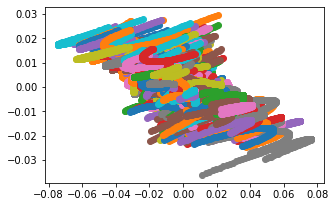

In [8]:
pltN(RX)

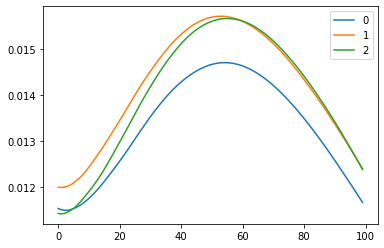

In [9]:
plt.figure()
plt.plot(np.mean(np.abs(wtf_diff(RX)),axis=1))
plt.legend([str(a) for a in range(RX.shape[1])])
plt.show() 

In [233]:
def normal_equation(X,Y):
    #sanity check failed
    try:
        XX = np.linalg.inv(X@X.T)
    except np.linalg.LinAlgError:
        print(f'cant inverse {X@X.T}')
        raise np.linalg.LinAlgError
    return ((XX@X)@Y.T).T
X = np.random.randn(N,500)
B = np.random.randn(N,N)
Y=B@X
B-normal_equation(X,Y)

array([[ 2.22044605e-16,  2.77555756e-17, -2.77555756e-16],
       [-2.22044605e-16,  0.00000000e+00,  2.77555756e-17],
       [ 2.22044605e-16, -2.22044605e-16, -3.33066907e-16]])

In [234]:
diff = wtf_diff(RX)
Gee = []
for g,d in zip(RX[:-1],diff):
    Gee.append(np.linalg.lstsq(g[:,:],100*d[:,:])[0])
    #Gee.append(normal_equation(g[:,:].T,100*d[:,:].T))


C:\Users\water\AppData\Local\Temp/ipykernel_18032/3482176461.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Gee.append(np.linalg.lstsq(g[:,:],100*d[:,:])[0])


In [235]:
RX.shape

(100, 1000, 3)

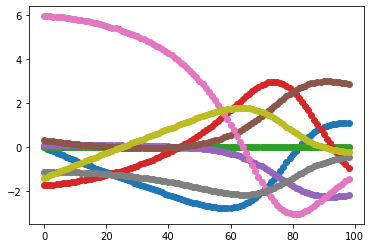

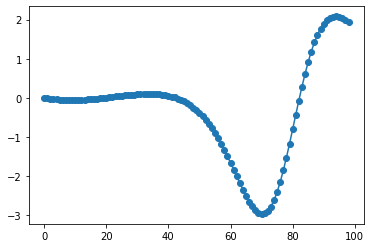

In [236]:
plt.figure()
plt.plot(np.stack([G.flatten() for G in Gee],axis=1).T,'o-')
plt.show()
plt.figure()
plt.plot([np.linalg.det(G) for G in Gee],'o-')
plt.show()


In [124]:
Gee[0].shape

(3, 3)

In [226]:
def wtf_diff(X):
    out = np.zeros_like(X)
    for i in range(X.shape[0]-1):
        out[i] = X[i+1]-X[i]
    return out

In [12]:
def norm(x):
    return np.sqrt(np.sum(x**2))
def normalize(x):
    mag = norm(x)
    return x / mag
def rk_iter(dt,f,Df,Phi,state):()
    k1=dt*Df(Phi,state)
    k2=dt*Df(Phi+k1/2,state)
    k3=dt*Df(Phi+k2/2,state)
    k4=dt*Df(Phi+k3,state)
    Phi=Phi+k1/6+k2/3+k3/3+k4/6

    k1=dt*f(state)
    k2=dt*f(state+k1/2)
    k3=dt*f(state+k2/2)
    k4=dt*f(state+k3)
    state=state+k1/6+k2/3+k3/3+k4/6
    return Phi, state
def rk_iter_nophi(dt,f,Df,state):
    k1=dt*f(state)
    k2=dt*f(state+k1/2)
    k3=dt*f(state+k2/2)
    k4=dt*f(state+k3)
    state=state+k1/6+k2/3+k3/3+k4/6
    return state

def couple_o_steps(f,Df,x0,DT,substeps,couple=10):
    state = x0
    for i in range(couple):
        dt = DT/substeps
        for j in range(substeps):
            state = rk_iter_nophi(dt,f,Df,state) #mostly just using this for the state, so ignoring the phi. 
    return state


def just_integrate(T,f,Df,x0,DT,substeps,transient=0,shorttime=1000):
    def step(state):
        delta_state = state
        for j in range(substeps):
            state = rk_iter_nophi(dt,f,Df,state)
        delta_state = state-delta_state
        return state, delta_state
    dt = DT/substeps
    state = x0
    n=len(x0)
    X = np.zeros((T,n))
    for i in range(T+transient):
        state, ds = step(state)
        X[i] = state
    return X


def local_CLLV(T,f,Df,x0,DT,substeps,transient=1,shorttime=1000,init_spread=1):
    
    def step(state,Phi):
        delta_state = state
        for j in range(substeps):
            Phi,state = rk_iter(dt,f,Df,Phi,state)
        delta_state = state-delta_state
        return state, Phi, delta_state

    #initializing variables    
    dt = DT/substeps
    state = x0
    n=len(x0)
    X = np.zeros((T,n))
    Phi = np.eye(n)
    allPhi = np.zeros((T,n,n))
    allGecobian = np.zeros((T,n-1,n-1))
    allExpansionRates = np.zeros((T,n))
    allExpansionRatesG = np.zeros((T,n-1))
    LyapExp = np.zeros((n-1,))

    shortTimeLyap = np.zeros((T+shorttime-1,n-1))
    allBasis = np.zeros((T+transient,n,n))
    allRs = np.zeros((T+transient,n,n))
    allRgs = np.zeros((T+transient,n-1,n-1))
    allRots = np.zeros((T+transient,n,n))
    allBasis_g = np.zeros((T+transient,n-1,n-1))
    allOmega = np.zeros((T+transient,n))

    rotation_manager = utils.rot_keeper(d=3)

    sigmas = init_spread*np.eye(n-1)

    # get some inital values in 1 step

    """
    state, Phi, ds = step(state,Phi)
    print(Phi)
    R = rotation_manager.get_rot(ds)

    Rhi = R@Phi
    Fhi = Rhi[0,:]
    G = Rhi[1:,1:]

    #LyapExp = (np.log(np.abs(rd))+LyapExp); #changed statement because i is zero indexed now   
    basis_g = G
    basis_g,r_g = np.linalg.qr(basis_g,'complete')
    rd_g = np.diag(r_g)
    basis_g = basis_g@np.diag(np.sign(rd_g))
    rd_g = np.abs(rd_g)
    G = basis_g
    Phi[1:,1:] = G
    Phi = R.T@Phi
    """
    
    for i in range(T+transient):

        state, Phi, ds = step(state,Phi)

        allRots[i] = rotation_manager.get_rot(ds)

        Phi = allRots[i]@Phi
        allOmega[i,:] = Phi[0,:]/ds
        G = Phi[1:,1:]

        basis_g = G
        basis_g,r_g = np.linalg.qr(basis_g,'complete')
        rd_g = np.diag(r_g)
        basis_g = basis_g@np.diag(np.sign(rd_g))
        r_g = np.diag(np.sign(rd_g))@r_g
        LyapExp = (np.log(np.diag(r_g))+LyapExp*i)/(1+i)
        G = basis_g
        
        Phi[1:,1:] = G
        Phi = R.T@Phi

        if i<=T-1:
            X[i,:] = state
            #allJacobian[i,:,:] = Phi@np.linalg.inv(basis) #replaces Phi/basis
            allGecobian[i,:,:] = G@np.linalg.inv(basis_g) #replaces Phi/basis

        allRgs[i,:,:] = r_g
        allBasis_g[i,:,:] = basis_g

        

        if (i<T+shorttime-1):
            shortTimeLyap[i,:] = np.log(np.diag(r_g))

    shortTimeLyap[0:(T),:] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(shorttime)/shorttime, mode='valid'), 
                                                    axis=0, arr=shortTimeLyap)
    shortTimeLyap = shortTimeLyap[:T,:]/DT

    coeff = np.triu(np.random.rand(n,n))
    coeff_g = np.triu(np.random.rand(n-1,n-1))
    for jj in range(n):
        coeff[:,jj] = normalize(coeff[:,jj])
    for jj in range(n-1):
        coeff_g[:,jj] = normalize(coeff_g[:,jj])

    for i in range(T+transient-1,0,-1):
        #coeff = np.linalg.solve(np.squeeze(allRs[i,:,:]),coeff); # same as squeeze(allRs(i,:,:))\coeff;
        #coeff = np.triu(coeff)
        coeff_g = np.linalg.solve(np.squeeze(allRgs[i,:,:]),coeff_g); # same as squeeze(allRs(i,:,:))\coeff;
        coeff_g = np.triu(coeff_g)

        #for jj in range(n):
            #if (i<=T-1):
                #allExpansionRates[i,jj] = 1/norm(coeff[:,jj]) # ./ -> /
            #coeff[:,jj] = normalize(coeff[:,jj])
        for jj in range(n-1):
            if (i<=T-1):
                allExpansionRatesG[i,jj] = 1/norm(coeff_g[:,jj]) # ./ -> /
            coeff_g[:,jj] = normalize(coeff_g[:,jj])

        #allBasis[i,:,:] = np.squeeze(allBasis[i,:,:])@coeff
        allBasis_g[i,:,:] = np.squeeze(allBasis_g[i,:,:])@coeff_g

        #for jj in range(n):
        #    allBasis[i,:,jj] = normalize(allBasis[i,:,jj])
        for jj in range(n-1):
            allBasis_g[i,:,jj] = normalize(allBasis_g[i,:,jj])

    #allBasis = allBasis[:T,:,:]
    allBasis_g = allBasis_g[:T,:,:]

    return X, allBasis_g, allRgs, allJacobian, allGecobian, allExpansionRatesG, shortTimeLyap, allRots, LyapExp
class rot_keeper(object):
    def __init__(self,d=3):
        assert(d>2)
        self.d=d
        self.e1 = np.zeros(d)
        self.e1[0]=1.0
        self.e1_sm = np.zeros(d-1)
        self.e1_sm[0]=1.0
        self.e2 = np.zeros(d)
        self.e2[1]=1.0
        self.R = np.eye(d)

    def get_rot(self,u):
        Rs = utils.rot_mat(u,self.e1)
        e2old = self.R.T@self.e2
        Rpp = np.eye(self.d)
        Rpp[1:,1:] = utils.rot_mat((Rs@e2old)[1:],self.e1_sm)
        Rs = Rpp @ Rs
        self.R = Rs
        return Rs
def local_region(T,f,Jf,x0,DT,substeps,init_spread=1):
    
    def step(state):
        for j in range(substeps):
            state = rk_iter_nophi(dt,f,Jf,state)
        return state, Jf(state), f(state)

    #initializing variables    
    dt = DT/substeps
    state = x0
    n=len(x0)
    X = np.zeros((T,n))
    Phi = np.eye(n)
    allPhi = np.zeros((T,n,n))
    rotation_manager = rot_keeper(d=3)
    allRots = np.zeros((T,n,n))
    allG = np.zeros((T,n-1,n-1))
    allOmega = np.zeros((T,n))
    allDs = np.zeros((T,n))

    sigmas = init_spread*np.eye(n-1)

    # get some inital values in 1 step

    """
    state, Phi, ds = step(state,Phi)
    print(Phi)
    R = rotation_manager.get_rot(ds)

    Rhi = R@Phi
    Fhi = Rhi[0,:]
    G = Rhi[1:,1:]

    #LyapExp = (np.log(np.abs(rd))+LyapExp); #changed statement because i is zero indexed now   
    basis_g = G
    basis_g,r_g = np.linalg.qr(basis_g,'complete')
    rd_g = np.diag(r_g)
    basis_g = basis_g@np.diag(np.sign(rd_g))
    rd_g = np.abs(rd_g)
    G = basis_g
    Phi[1:,1:] = G
    Phi = R.T@Phi
    """
    
    for i in range(T):

        state, Phi, ds = step(state)
        allDs[i] = ds
        X[i] = state

        allRots[i] = rotation_manager.get_rot(ds)
        print(Phi)
        Phi = allRots[i]@Phi
        print(Phi)
        allOmega[i,:] = Phi[0,:]#/np.sqrt(np.sum(ds**2))
        G = Phi[1:,1:]
        print(allOmega[i,:])
        print(G)

        allG[i,:,:] = G
        

    return X, allG, allOmega, allRots, allDs


In [ ]:
T = 50;
DT=0.01;
substeps=2;
x0 = pnts[:,0]
lborentz = lambda x:borentz(0,x)
X, allG, allOmega, allRots, allDs = local_region(T,aa,Jaa,x0,DT,substeps)
plt3(X)
plt.figure()
for i,G in enumerate(allG):
    plt.scatter(G[:,0],G[:,1],c=[0,1])
plt.show()

In [ ]:
def plt3(x):
    plt.figure()
    plt.subplot(2,1,1)
    plt.scatter(x[:,0],x[:,1],c='r')
    plt.ylabel('y')
    plt.subplot(2,1,2)
    plt.scatter(x[:,0],x[:,2],c='r')
    plt.ylabel('z')
    plt.xlabel('x')
    plt.show()
def scat_and_dist(x,y,fig=None):
    from matplotlib.gridspec import GridSpec

    if fig is None:
        fig = plt.figure()
    gs = GridSpec(4, 4)

    ax_scatter = fig.add_subplot(gs[1:4, 0:3])
    ax_hist_x = fig.add_subplot(gs[0,0:3])
    ax_hist_y = fig.add_subplot(gs[1:4, 3])

    ax_scatter.scatter(x,y)
    ax_scatter.axis('equal')

    ax_hist_x.hist(x)
    ax_hist_y.hist(y, orientation = 'horizontal')

    plt.show()

In [314]:
def borentz(t,x, sigma = 10, rho = 28, beta = 8/3):
    dx = np.zeros((3,))
    dx[0] =  (x[1] - x[0])
    dx[1] = - x[2] - x[1]
    dx[2] = x[0]  - beta * x[2]
    return dx
def Jborentz(x, sigma = 10, rho = 28, beta = 8/3):
    J=[[-1,    1,       0],
       [0,     -1,   -1],
       [1,          0, -beta]]
    return np.array(J)


def aa(x, sigma = 10, rho = 28, beta = 8/3):
    dx = np.zeros((3,))
    dx[0] =  - x[0]
    dx[1] =  - x[1]
    dx[2] =  - x[2]
    return dx
def Jaa(x, sigma = 10, rho = 28, beta = 8/3):
    J=- np.eye(3)
    return np.array(J)


[[-1. -0. -0.]
 [-0. -1. -0.]
 [-0. -0. -1.]]
[[ 5.77350269e-01  5.77350269e-01  5.77350269e-01]
 [ 4.08248290e-01 -8.16496581e-01  4.08248290e-01]
 [ 7.07106781e-01 -4.03199798e-17 -7.07106781e-01]]
[0.57735027 0.57735027 0.57735027]
[[-8.16496581e-01  4.08248290e-01]
 [-4.03199798e-17 -7.07106781e-01]]
[[-1. -0. -0.]
 [-0. -1. -0.]
 [-0. -0. -1.]]
[[ 5.77350269e-01  5.77350269e-01  5.77350269e-01]
 [ 4.08248290e-01 -8.16496581e-01  4.08248290e-01]
 [ 7.07106781e-01 -1.59929887e-16 -7.07106781e-01]]
[0.57735027 0.57735027 0.57735027]
[[-8.16496581e-01  4.08248290e-01]
 [-1.59929887e-16 -7.07106781e-01]]
[[-1. -0. -0.]
 [-0. -1. -0.]
 [-0. -0. -1.]]
[[ 5.77350269e-01  5.77350269e-01  5.77350269e-01]
 [ 4.08248290e-01 -8.16496581e-01  4.08248290e-01]
 [ 7.07106781e-01 -3.90562097e-16 -7.07106781e-01]]
[0.57735027 0.57735027 0.57735027]
[[-8.16496581e-01  4.08248290e-01]
 [-3.90562097e-16 -7.07106781e-01]]
[[-1. -0. -0.]
 [-0. -1. -0.]
 [-0. -0. -1.]]
[[ 5.77350269e-01  5.77350269e-01  5

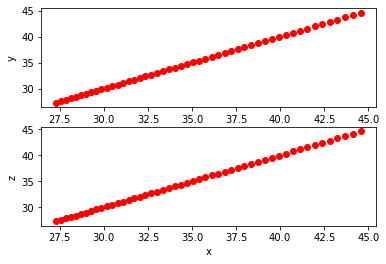

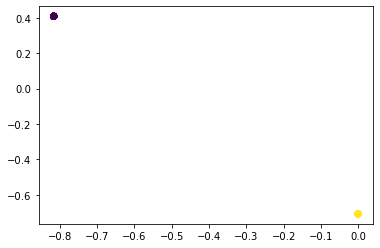

In [317]:
T = 50;
DT=0.01;
substeps=2;
x0 = 45*np.ones((3,))# pnts[:,0]
lborentz = lambda x:borentz(0,x)
X, allG, allOmega, allRots, allDs = local_region(T,aa,Jaa,x0,DT,substeps)
plt3(X)
plt.figure()
for i,G in enumerate(allG):
    plt.scatter(G[:,0],G[:,1],c=[0,1])
plt.show()

In [323]:
R@np.array([1,1,1])

array([-0.51406411,  1.63956866, -0.2180658 ])

In [318]:
paths = []
deltax = []
npaths = 100
spread = 0.1
for n in range(npaths):
    deltax.append(np.random.randn(3,)*spread)
    paths.append(just_integrate(T,aa,Jaa,x0+deltax[-1],DT,substeps,transient=0,shorttime=5))


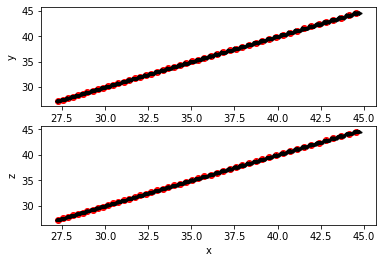

In [319]:
plt.figure()
plt.subplot(2,1,1)
plt.scatter(X[:,0],X[:,1],c='r')
for p in paths:
    plt.scatter(p[:,0],p[:,1],c='k',s=1)
plt.ylabel('y')
plt.subplot(2,1,2)
plt.scatter(X[:,0],X[:,2],c='r')
for p in paths:
    plt.scatter(p[:,0],p[:,2],c='k',s=1)
plt.ylabel('z')
plt.xlabel('x')
plt.show()

[[-0.99922569 -0.0393448 ]
 [ 0.0393448  -0.99922569]]


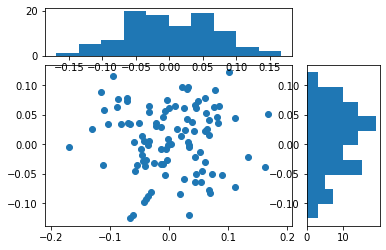

gx 0.0644
gy 0.0564
w 0.0623


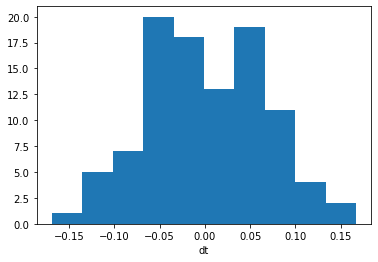

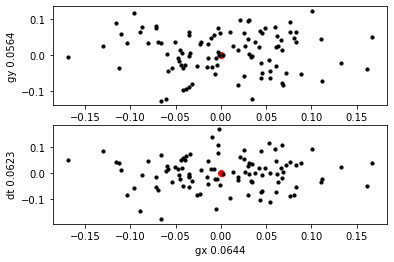

In [320]:
#rotated
at = -1

xh = allRots[at]@X[at,:]
ph = []
for p in paths:
    ph.append(xh-allRots[at]@p[at,:])

ph = np.stack(ph)
_,_,rr = np.linalg.svd(ph[:,1:])
print(rr)
ph[:,1:] = (rr@ph[:,1:].T).T

scat_and_dist([p[1] for p in ph],[p[2] for p in ph])
print(f'gx {np.std([p[1] for p in ph]):.4f}')
print(f'gy {np.std([p[2] for p in ph]):.4f}')
print(f'w {np.std([p[0] for p in ph]):.4f}')
plt.figure()
plt.hist([p[1] for p in ph])
plt.xlabel('dt')
plt.show()


plt.figure()
plt.subplot(2,1,1)
plt.scatter(0,0,c='r')
for p in ph:
    plt.scatter(p[1],p[2],c='k',s=10)
plt.ylabel(f'gy {np.std([p[2] for p in ph]):.4f}')
plt.subplot(2,1,2)
plt.scatter(0,0,c='r')
for p in ph:
    plt.scatter(p[1],p[0],c='k',s=10)
plt.ylabel(f'dt {np.std([p[0] for p in ph]):.4f}')
plt.xlabel(f'gx {np.std([p[1] for p in ph]):.4f}')
plt.show()

In [321]:
s = spread*np.ones(2)
for G in allG:
    f = lambda q: G@q
    dF = lambda q:q
    s = couple_o_steps(f,dF,s,DT,substeps,couple=1)
s

array([0.08042981, 0.07021885])

In [309]:
G

array([[-8.16496581e-01,  4.08248290e-01],
       [-1.94382614e-15, -7.07106781e-01]])

In [245]:
t = spread*np.ones(3)
for g,w in zip(allG,allOmega):
    f = lambda q: w.T@q
    dF = lambda q:q
    print(a)
    a = couple_o_steps(f,dF,a,DT,substeps,couple=1)
a

[0.1 0.1]
[0.09815472 0.09739372]
[0.0963499  0.09484674]
[0.09458471 0.09235834]
[0.09285835 0.08992777]
[0.09116999 0.08755423]
[0.08951883 0.08523691]
[0.08790407 0.08297496]
[0.0863249  0.08076753]
[0.08478055 0.0786137 ]
[0.08327023 0.07651259]
[0.08179317 0.07446326]
[0.08034861 0.07246478]
[0.0789358 0.0705162]
[0.077554   0.06861657]
[0.07620249 0.06676493]
[0.07488055 0.06496031]
[0.07358748 0.06320176]
[0.07232259 0.06148829]
[0.07108521 0.05981896]
[0.06987467 0.0581928 ]
[0.06869032 0.05660886]
[0.06753153 0.05506619]
[0.06639769 0.05356385]
[0.06528817 0.05210091]
[0.0642024  0.05067645]
[0.06313978 0.04928956]
[0.06209976 0.04793934]
[0.06108178 0.0466249 ]
[0.06008531 0.04534538]
[0.05910981 0.0440999 ]
[0.05815477 0.04288763]
[0.05721971 0.04170773]
[0.05630412 0.04055939]
[0.05540754 0.0394418 ]
[0.0545295  0.03835419]
[0.05366956 0.03729577]
[0.05282728 0.03626579]
[0.05200223 0.03526352]
[0.051194   0.03428823]
[0.05040219 0.03333922]
[0.04962639 0.03241579]
[0.04886

array([0.04330561, 0.02514958])

In [230]:
def couple_o_steps(f,Df,x0,DT,substeps,couple=10):
    state = x0
    for i in range(couple):
        dt = DT/substeps
        for j in range(substeps):
            state = rk_iter_nophi(dt,f,Df,state) #mostly just using this for the state, so ignoring the phi. 
    return state

array([[[-9.98987577e-01, -1.11082698e+00],
        [ 2.40764121e-15, -9.64727338e-01]],

       [[-9.98495798e-01, -1.13476467e+00],
        [ 1.73287397e-04, -9.74113318e-01]],

       [[-9.97901549e-01, -1.15876161e+00],
        [ 3.80379949e-04, -9.83261211e-01]],

       [[-9.97202466e-01, -1.18280873e+00],
        [ 6.19955271e-04, -9.92166805e-01]],

       [[-9.96396238e-01, -1.20689688e+00],
        [ 8.90599612e-04, -1.00082615e+00]],

       [[-9.95480615e-01, -1.23101685e+00],
        [ 1.19080908e-03, -1.00923556e+00]],

       [[-9.94453408e-01, -1.25515936e+00],
        [ 1.51899110e-03, -1.01739161e+00]],

       [[-9.93312497e-01, -1.27931511e+00],
        [ 1.87346610e-03, -1.02529119e+00]],

       [[-9.92055828e-01, -1.30347475e+00],
        [ 2.25246946e-03, -1.03293144e+00]],

       [[-9.90681422e-01, -1.32762893e+00],
        [ 2.65415364e-03, -1.04030981e+00]],

       [[-9.89187374e-01, -1.35176828e+00],
        [ 3.07659060e-03, -1.04742404e+00]],

       [[-

In [197]:
np.sqrt(np.sum((x[-1]-x[-2])**2))

0.009960178975268831

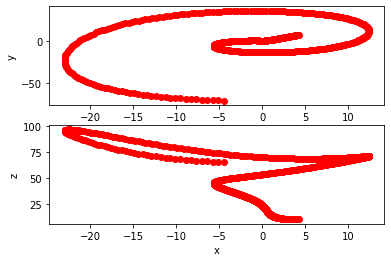

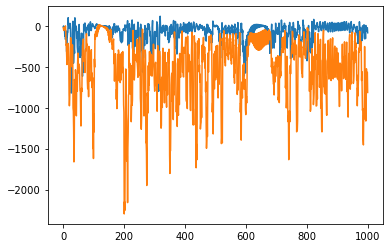

In [88]:
T = 1000;
DT=0.001;
substeps=2;
x0 = pnts[:,0]
llorentz = lambda x: lorentz(0,x)
X, allBasisG, allRGs, allJacobian,allGecobian,allExpansionRatesG,shortTimeLyap, allRots, LyapExp = local_CLLV(T,llorentz,Dlorentz,x0,DT,substeps,transient=22,shorttime=5)
plt3(X)
plt.figure()
plt.plot(shortTimeLyap)
plt.show()

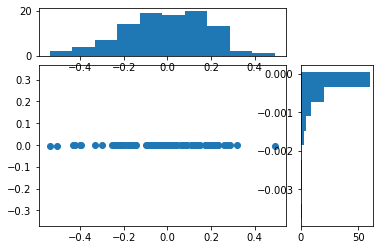

gx 0.1923
gy 0.0006
w 0.5572


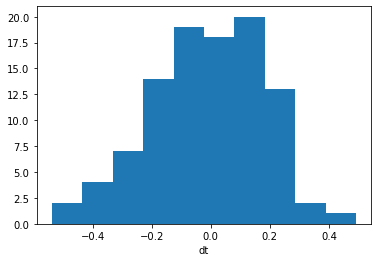

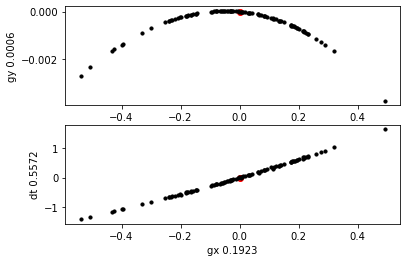

In [ ]:
#rotated
at = -1

xh = allRots[at]@X[at,:]
ph = []
for p in paths:
    ph.append(xh-allRots[at]@p[at,:])

ph = np.stack(ph)
_,_,rr = np.linalg.svd(ph[:,1:])

ph[:,1:] = (rr@ph[:,1:].T).T

scat_and_dist([p[1] for p in ph],[p[2] for p in ph])
print(f'gx {np.std([p[1] for p in ph]):.4f}')
print(f'gy {np.std([p[2] for p in ph]):.4f}')
print(f'w {np.std([p[0] for p in ph]):.4f}')
plt.figure()
plt.hist([p[1] for p in ph])
plt.xlabel('dt')
plt.show()


plt.figure()
plt.subplot(2,1,1)
plt.scatter(0,0,c='r')
for p in ph:
    plt.scatter(p[1],p[2],c='k',s=10)
plt.ylabel(f'gy {np.std([p[2] for p in ph]):.4f}')
plt.subplot(2,1,2)
plt.scatter(0,0,c='r')
for p in ph:
    plt.scatter(p[1],p[0],c='k',s=10)
plt.ylabel(f'dt {np.std([p[0] for p in ph]):.4f}')
plt.xlabel(f'gx {np.std([p[1] for p in ph]):.4f}')
plt.show()

In [71]:
Gtot = np.eye(2)
for G in allGecobian:
    Gtot=G@Gtot
Gtot

array([[ 5.59060179e-37,  2.15171323e-35],
       [-1.90659782e-36, -7.33812191e-35]])

In [73]:
np.exp(LyapExp)*spread

array([0.09242875, 0.05925719])

In [48]:
paths = []
deltax = []
npaths = 100
spread = 0.1
for n in range(npaths):
    deltax.append(np.random.randn(3,)*spread)
    paths.append(just_integrate(T,llorentz,Dlorentz,x0+deltax[-1],DT,substeps,transient=0,shorttime=5))


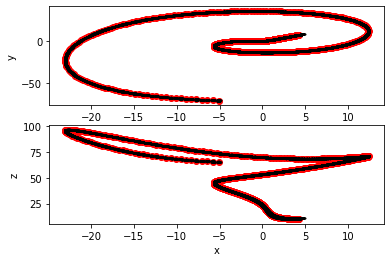

In [49]:
plt.figure()
plt.subplot(2,1,1)
plt.scatter(X[:,0],X[:,1],c='r')
for p in paths:
    plt.scatter(p[:,0],p[:,1],c='k',s=1)
plt.ylabel('y')
plt.subplot(2,1,2)
plt.scatter(X[:,0],X[:,2],c='r')
for p in paths:
    plt.scatter(p[:,0],p[:,2],c='k',s=1)
plt.ylabel('z')
plt.xlabel('x')
plt.show()

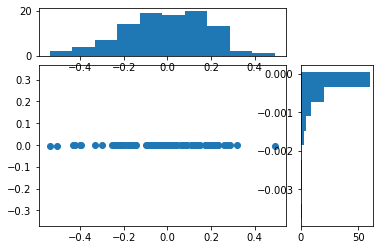

gx 0.1923
gy 0.0006
w 0.5572


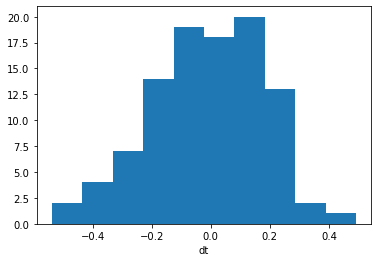

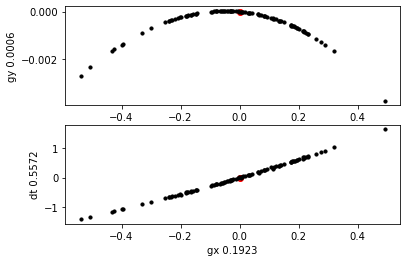

In [74]:
#rotated
at = -1

xh = allRots[at]@X[at,:]
ph = []
for p in paths:
    ph.append(xh-allRots[at]@p[at,:])

ph = np.stack(ph)
_,_,rr = np.linalg.svd(ph[:,1:])

ph[:,1:] = (rr@ph[:,1:].T).T

scat_and_dist([p[1] for p in ph],[p[2] for p in ph])
print(f'gx {np.std([p[1] for p in ph]):.4f}')
print(f'gy {np.std([p[2] for p in ph]):.4f}')
print(f'w {np.std([p[0] for p in ph]):.4f}')
plt.figure()
plt.hist([p[1] for p in ph])
plt.xlabel('dt')
plt.show()


plt.figure()
plt.subplot(2,1,1)
plt.scatter(0,0,c='r')
for p in ph:
    plt.scatter(p[1],p[2],c='k',s=10)
plt.ylabel(f'gy {np.std([p[2] for p in ph]):.4f}')
plt.subplot(2,1,2)
plt.scatter(0,0,c='r')
for p in ph:
    plt.scatter(p[1],p[0],c='k',s=10)
plt.ylabel(f'dt {np.std([p[0] for p in ph]):.4f}')
plt.xlabel(f'gx {np.std([p[1] for p in ph]):.4f}')
plt.show()

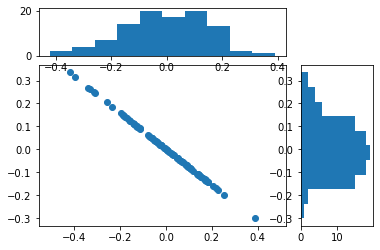

gx 0.1510
gy 0.1191


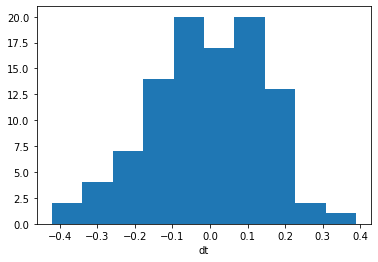

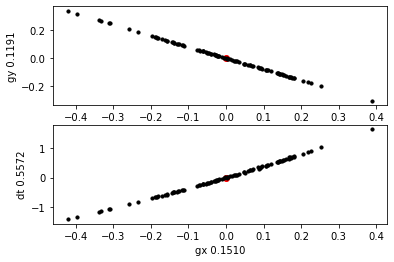

In [ ]:
#rotated
at = -1

xh = allRots[at]@X[at,:]
ph = []
for p in paths:
    ph.append(xh-all`Rots[at]@p[at,:])
`
scat_and_dist([p[1] for p in ph],[p[2] for p in ph])
print(f'gx {np.std([p[1] for p in ph]):.4f}')
print(f'gy {np.std([p[2] for p in ph]):.4f}')
plt.figure()
plt.hist([p[1] for p in ph])
plt.xlabel('dt')
plt.show()


plt.figure()
plt.subplot(2,1,1)
plt.scatter(0,0,c='r')
for p in ph:
    plt.scatter(p[1],p[2],c='k',s=10)
plt.ylabel(f'gy {np.std([p[2] for p in ph]):.4f}')
plt.subplot(2,1,2)
plt.scatter(0,0,c='r')
for p in ph:
    plt.scatter(p[1],p[0],c='k',s=10)
plt.ylabel(f'dt {np.std([p[0] for p in ph]):.4f}')
plt.xlabel(f'gx {np.std([p[1] for p in ph]):.4f}')
plt.show()

In [16]:
np.linalg.eig?

Signature: np.linalg.eig(a)
Docstring:
Compute the eigenvalues and right eigenvectors of a square array.

Parameters
----------
a : (..., M, M) array
    Matrices for which the eigenvalues and right eigenvectors will
    be computed

Returns
-------
w : (..., M) array
    The eigenvalues, each repeated according to its multiplicity.
    The eigenvalues are not necessarily ordered. The resulting
    array will be of complex type, unless the imaginary part is
    zero in which case it will be cast to a real type. When `a`
    is real the resulting eigenvalues will be real (0 imaginary
    part) or occur in conjugate pairs

v : (..., M, M) array
    The normalized (unit "length") eigenvectors, such that the
    column ``v[:,i]`` is the eigenvector corresponding to the
    eigenvalue ``w[i]``.

Raises
------
LinAlgError
    If the eigenvalue computation does not converge.

See Also
--------
eigvals : eigenvalues of a non-symmetric array.
eigh : eigenvalues and eigenvectors of a real symmet

In [21]:
np.exp(LyapExp)

array([0.72626873, 0.46826548])

In [23]:
0.809*.46

0.37214

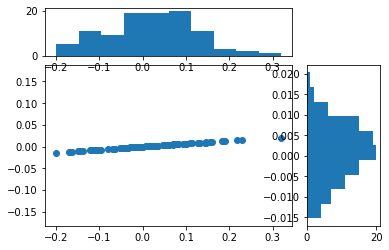

gx 0.0991
gy 0.0069


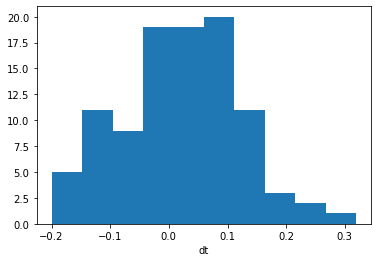

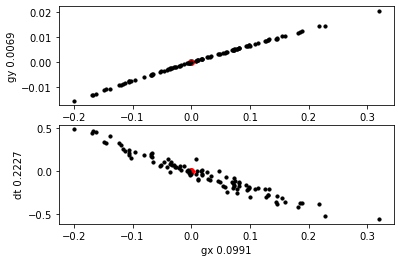

In [18]:
#rotated
at = -1

xh = allRots[at]@X[at,:]
ph = []
for p in paths:
    ph.append(xh-allRots[at]@p[at,:])

scat_and_dist([p[1] for p in ph],[p[2] for p in ph])
print(f'gx {np.std([p[1] for p in ph]):.4f}')
print(f'gy {np.std([p[2] for p in ph]):.4f}')
plt.figure()
plt.hist([p[1] for p in ph])
plt.xlabel('dt')
plt.show()


plt.figure()
plt.subplot(2,1,1)
plt.scatter(0,0,c='r')
for p in ph:
    plt.scatter(p[1],p[2],c='k',s=10)
plt.ylabel(f'gy {np.std([p[2] for p in ph]):.4f}')
plt.subplot(2,1,2)
plt.scatter(0,0,c='r')
for p in ph:
    plt.scatter(p[1],p[0],c='k',s=10)
plt.ylabel(f'dt {np.std([p[0] for p in ph]):.4f}')
plt.xlabel(f'gx {np.std([p[1] for p in ph]):.4f}')
plt.show()

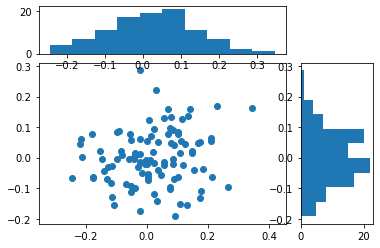

gx 0.1157
gy 0.0890


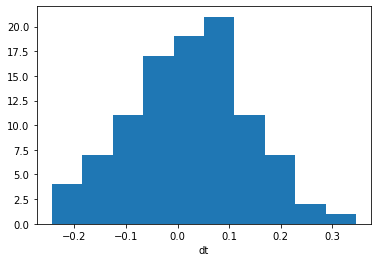

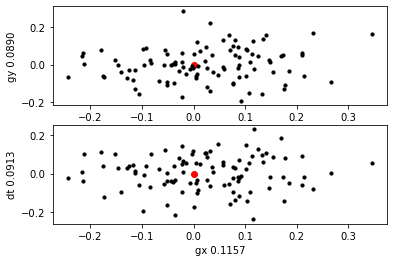

In [19]:
#rotated
at = 1

xh = allRots[at]@X[at,:]
ph = []
for p in paths:
    ph.append(xh-allRots[at]@p[at,:])

scat_and_dist([p[1] for p in ph],[p[2] for p in ph])
print(f'gx {np.std([p[1] for p in ph]):.4f}')
print(f'gy {np.std([p[2] for p in ph]):.4f}')
plt.figure()
plt.hist([p[1] for p in ph])
plt.xlabel('dt')
plt.show()


plt.figure()
plt.subplot(2,1,1)
plt.scatter(0,0,c='r')
for p in ph:
    plt.scatter(p[1],p[2],c='k',s=10)
plt.ylabel(f'gy {np.std([p[2] for p in ph]):.4f}')
plt.subplot(2,1,2)
plt.scatter(0,0,c='r')
for p in ph:
    plt.scatter(p[1],p[0],c='k',s=10)
plt.ylabel(f'dt {np.std([p[0] for p in ph]):.4f}')
plt.xlabel(f'gx {np.std([p[1] for p in ph]):.4f}')
plt.show()

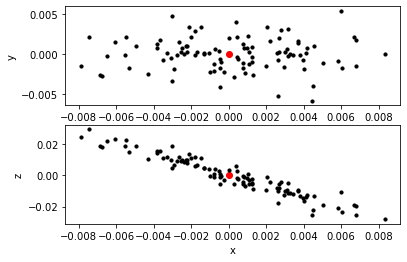

In [98]:
at = -11
plt.figure()
plt.subplot(2,1,1)
plt.scatter(0,0,c='r')
for p in paths:
    plt.scatter(X[at,0]-p[at,0],X[at,1]-p[at,1],c='k',s=10)
plt.ylabel('y')
plt.subplot(2,1,2)
plt.scatter(0,0,c='r')
for p in paths:
    plt.scatter(X[at,0]-p[at,0],X[at,2]-p[at,2],c='k',s=10)
plt.ylabel('z')
plt.xlabel('x')
plt.show()

In [15]:
T = 1000;
DT=0.001;
substeps=2;
x0 = pnts[:,0]
llorentz = lambda x: lorentz(0,x)
f=llorentz
Df=Dlorentz
transient=0
shorttime=5
    
def step(state,Phi):
    delta_state = state
    for j in range(substeps):
        Phi,state = rk_iter(dt,f,Df,Phi,state)
    delta_state = state-delta_state
    return state, Phi, delta_state

#initializing variables    
state = x0
n=len(x0)
X = np.zeros((T,n))
Phi = np.eye(n)
allJacobian = np.zeros((T,n,n))
allGecobian = np.zeros((T,n-1,n-1))
allExpansionRates = np.zeros((T,n))
LyapExp = np.zeros((n-1,))

shortTimeLyap = np.zeros((T+shorttime-1,n-1))
allBasis = np.zeros((T+transient,n,n))
allRs = np.zeros((T+transient,n,n))
allBasis_g = np.zeros((T+transient,n-1,n-1))
allRs_g = np.zeros((T+transient,n-1,n-1))
allOmega = np.zeros((T+transient,n))

rotation_manager = utils.rot_keeper(d=3)

# get some inital values in 1 step
dt = DT/substeps

state, Phi, ds = step(state,Phi)

R = rotation_manager.get_rot(ds)

Phi = R@Phi
Fhi = Phi[0,:]
G = Phi[1:,1:]

basis = Phi
basis,r = np.linalg.qr(basis,'complete')
rd = np.diag(r)
basis = basis@np.diag(np.sign(rd))
rd = np.abs(rd)
Phi = basis
#LyapExp = (np.log(np.abs(rd))+LyapExp); #changed statement because i is zero indexed now   
basis_g = G
basis_g,r_g = np.linalg.qr(basis_g,'complete')
rd_g = np.diag(r_g)
basis_g = basis_g@np.diag(np.sign(rd_g))
rd_g = np.abs(rd_g)
G = basis_g


In [16]:
for i in range(T+transient):

    dt = DT/substeps

    state, Phi, ds = step(state,Phi)

    R = rotation_manager.get_rot(ds)

    Phi = R@Phi
    allOmega[i,:] = Phi[0,:]/ds
    G = Phi[1:,1:]


    if i<=T-1:
        X[i,:] = state
        allJacobian[i,:,:] = Phi@np.linalg.inv(basis) #replaces Phi/basis
        allGecobian[i,:,:] = G@np.linalg.inv(basis_g) #replaces Phi/basis

    basis = Phi
    basis,r = np.linalg.qr(basis,'complete')
    rd = np.diag(r)
    basis = basis@np.diag(np.sign(rd))
    r = np.diag(np.sign(rd))@r
    Phi = basis

    basis_g = G
    basis_g,r_g = np.linalg.qr(basis_g,'complete')
    rd_g = np.diag(r_g)
    basis_g = basis_g@np.diag(np.sign(rd_g))
    r_g = np.diag(np.sign(rd_g))@r_g
    LyapExp = (np.log(np.diag(r_g))+LyapExp*i)/(1+i)
    G = basis_g

    allRs[i,:,:] = r
    allBasis[i,:,:] = basis

    if (i<T+shorttime-1):
        shortTimeLyap[i,:] = np.log(np.diag(r_g))

shortTimeLyap[0:(T),:] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(shorttime)/shorttime, mode='valid'), 
                                                axis=0, arr=shortTimeLyap)
shortTimeLyap = shortTimeLyap[:T,:]/DT

coeff = np.triu(np.random.rand(n,n))
for jj in range(n):
    coeff[:,jj] = normalize(coeff[:,jj])

for i in range(T+transient-1,0,-1):

    coeff = np.linalg.solve(np.squeeze(allRs[i,:,:]),coeff); # same as squeeze(allRs(i,:,:))\coeff;
    coeff = np.triu(coeff)

    for jj in range(n):
        if (i<=T-1):
            allExpansionRates[i,jj] = 1/norm(coeff[:,jj]) # ./ -> /
        coeff[:,jj] = normalize(coeff[:,jj])

    allBasis[i,:,:] = np.squeeze(allBasis[i,:,:])@coeff

    for jj in range(n):
        allBasis[i,:,jj] = normalize(allBasis[i,:,jj])

allBasis = allBasis[:T,:,:]

